In [3]:
import json
import requests
from bs4 import BeautifulSoup
from espncricinfo.exceptions import MatchNotFoundError, NoScorecardError
import pandas as pd

class Match(object):
    def __init__(self, match_id):
        self.match_id = match_id
        self.match_url = f"https://site.api.espn.com/apis/site/v2/sports/cricket/8048/summary?event={match_id}"
        self.json_url = f"https://www.espncricinfo.com/matches/engine/match/{match_id}.json"
        self.json = self.get_json()
        self.json_api = self.get_json_api()
        self.description = self.get_description()
        self.full_scorecard_url = self.get_full_scorecard_url()
        self.toss = self.get_toss()
        self.team1 = self.get_team1()
        self.team2 = self.get_team2()
        self.team1_batting_df = self.get_team1_batting_df()
        self.team2_batting_df = self.get_team2_batting_df()
        self.team1_bowling_df = self.get_team1_bowling_df()
        self.team2_bowling_df = self.get_team2_bowling_df()
        self.dream11_points = self.get_dream11_points()
        
        

    def get_json(self):
        r = requests.get(self.json_url)
        if r.status_code == 404:
            raise MatchNotFoundError
        elif 'Scorecard not yet available' in r.text:
            raise NoScorecardError
        else:
            return r.json()
    
    def get_json_api(self):
        r = requests.get(self.match_url)
        if r.status_code == 404:
            raise MatchNotFoundError
        elif 'Scorecard not yet available' in r.text:
            raise NoScorecardError
        else:
            return r.json()
        
    def get_full_scorecard_url(self):
        url  = self.description
        matchName = url.split(",")[1].split(":")[1].strip().split(" ")[:-2]
        firstHalf = '-'.join(matchName).lower().replace("-v-", "-vs-")
        matchNo = url.split(",")[1].split(":")[0].replace(" ","-").lower()
        finalurl = firstHalf + matchNo + "-" + str(self.match_id)
        return f"https://www.espncricinfo.com/series/indian-premier-league-2024-1410320/{finalurl}/full-scorecard"
    
    def get_description(self):
        return self.json['description']
    
    def get_toss(self):
        return self.json_api['gameInfo']['venue']['fullName']
    
    def get_team1(self):
        team = []
        for i in self.json_api['rosters'][0]['roster']:
             team.append(i['athlete']['name'])
        return team
    
    def get_team2(self):
        team = []
        for i in self.json_api['rosters'][1]['roster']:
             team.append(i['athlete']['name'])
        return team
    
    def get_team1_batting_df(self):
        r = requests.get(self.full_scorecard_url)
        soup = BeautifulSoup(r.content, 'html.parser')
        df = pd.DataFrame(columns= ['Name', "Wicket", "Runs", "Balls", "Fours", "Sixes"])
        tables = soup.find_all('table')
        brows = tables[0].findAll('tr')[1:-4]
        for brow in brows[::2]:
            x  = brow.findAll('td')
            df.loc[len(df)] = [x[0].text, x[1].text, x[2].text, x[3].text, x[5].text, x[6].text]
        df["Runs"] = df["Runs"].astype(float)
        df[["Runs", "Balls", "Fours", "Sixes"]] = df[["Runs", "Balls", "Fours", "Sixes"]].astype(float)
        df["Strike Rate"] = (df["Runs"] / df["Balls"] * 100).round(2)
        return df

    def get_team2_batting_df(self):
        r = requests.get(self.full_scorecard_url)
        soup = BeautifulSoup(r.content, 'html.parser')
        df = pd.DataFrame(columns= ['Name', "Wicket", "Runs", "Balls", "Fours", "Sixes"])
        tables = soup.find_all('table')
        brows = tables[2].findAll('tr')[1:-4]
        for brow in brows[::2]:
            x  = brow.findAll('td')
            df.loc[len(df)] = [x[0].text, x[1].text, x[2].text, x[3].text, x[5].text, x[6].text]
        df["Runs"] = df["Runs"].astype(float)
        df[["Runs", "Balls", "Fours", "Sixes"]] = df[["Runs", "Balls", "Fours", "Sixes"]].astype(float)
        df["Strike Rate"] = (df["Runs"] / df["Balls"] * 100).round(2)
        return df
    
    def get_team1_bowling_df(self):
        table = pd.read_html(self.full_scorecard_url)
        df = table[1]
        df = df[~df['BOWLING'].str[0].str.isdigit()]
        return df
    
    def get_team2_bowling_df(self):
        table = pd.read_html(self.full_scorecard_url)
        df = table[3]
        df = df[~df['BOWLING'].str[0].str.isdigit()]
        return df
    
    def get_dream11_points(self):
        return None
    



In [4]:
matchNumber = 1426290
m = Match(matchNumber)
m.team1

['Virat Kohli',
 'Faf du Plessis',
 'Will Jacks',
 'Rajat Patidar',
 'Glenn Maxwell',
 'Cameron Green',
 'Dinesh Karthik',
 'Swapnil Singh',
 'Karn Sharma',
 'Mohammed Siraj',
 'Vijaykumar Vyshak',
 'Yash Dayal']

In [25]:
x = m.team2_batting_df
y = m.team1_batting_df

pd.concat([x,y]).sort_values(by= "Runs", ascending = False)

,Name,Wicket,Runs,Balls,Fours,Sixes,Strike Rate,Fantasy Points
1,Faf du Plessis (c),c Shahrukh Khan b Little,64.0,23.0,10.0,3.0,278.26,91.0
0,Virat Kohli,c †Saha b Noor Ahmad,42.0,27.0,2.0,4.0,155.56,56.0
3,M Shahrukh Khan,run out (Kohli),37.0,24.0,5.0,1.0,154.17,45.0
5,Rahul Tewatia,c Vyshak b Yash Dayal,35.0,21.0,5.0,1.0,166.67,43.0
4,David Miller,c Maxwell b Sharma,30.0,20.0,3.0,2.0,150.00,39.0
6,Dinesh Karthik †,not out,21.0,12.0,3.0,0.0,175.00,24.0
6,Rashid Khan,b Yash Dayal,18.0,14.0,2.0,1.0,128.57,23.0
7,Vijay Shankar,c Mohammed Siraj b Vyshak,10.0,7.0,2.0,0.0,142.86,12.0
2,Sai Sudharsan,c Kohli b Green,6.0,14.0,0.0,0.0,42.86,6.0
4,Glenn Maxwell,c Miller b Little,4.0,3.0,1.0,0.0,133.33,5.0


In [21]:
x["Fantasy Points"] = x["Runs"] + x["Fours"] + x["Sixes"]*2

x["Fantasy Points"][x["Runs"] > 50] = x["Fantasy Points"] + 8
x["Fantasy Points"][x["Runs"] > 100] = x["Fantasy Points"] + 16
x["Fantasy Points"][x["Runs"] == 0] = x["Fantasy Points"] - 2

y["Fantasy Points"] = y["Runs"] + y["Fours"] + y["Sixes"]*2
y["Fantasy Points"][y["Runs"] > 50] = y["Fantasy Points"] + 8
y["Fantasy Points"][y["Runs"] > 100] = y["Fantasy Points"] + 16
y["Fantasy Points"][y["Runs"] == 0] = y["Fantasy Points"] - 2

x


/tmp/ipykernel_6739/156663049.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x["Fantasy Points"][x["Runs"] > 50] = x["Fantasy Points"] + 8
/tmp/ipykernel_6739/156663049.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x["Fantasy Points"][x["Runs"] > 100] = x["Fantasy Points"] + 16
/tmp/ipykernel_6739/156663049.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x["Fantasy Points"][x["Runs"] == 0] = x["Fantasy Points"] - 2
/tmp/

,Name,Wicket,Runs,Balls,Fours,Sixes,Strike Rate,Fantasy Points
0,Virat Kohli,c †Saha b Noor Ahmad,42.0,27.0,2.0,4.0,155.56,56.0
1,Faf du Plessis (c),c Shahrukh Khan b Little,64.0,23.0,10.0,3.0,278.26,91.0
2,Will Jacks,c Shahrukh Khan b Noor Ahmad,1.0,3.0,0.0,0.0,33.33,1.0
3,Rajat Patidar,c Miller b Little,2.0,3.0,0.0,0.0,66.67,2.0
4,Glenn Maxwell,c Miller b Little,4.0,3.0,1.0,0.0,133.33,5.0
5,Cameron Green,c Shahrukh Khan b Little,1.0,2.0,0.0,0.0,50.00,1.0
6,Dinesh Karthik †,not out,21.0,12.0,3.0,0.0,175.00,24.0


<Axes: xlabel='Name'>

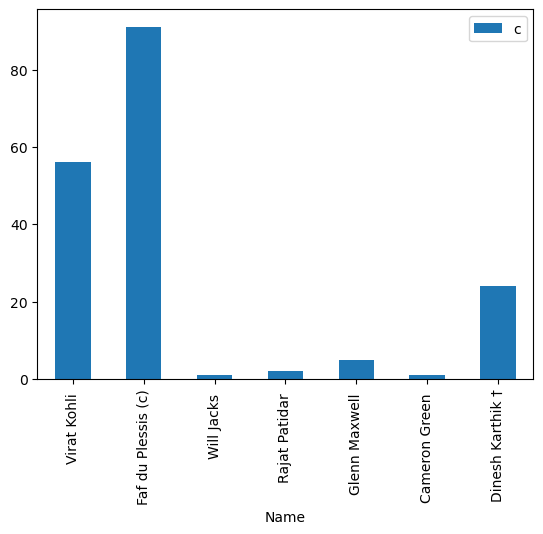

In [7]:
# x["Fantasy Points"].plot()
x.plot.bar(x='Name', y='Fantasy Points', label='c')